# Movie Recommendation System

## #CloudGuruChallenge – Machine Learning on AWS

### In this challenge, I have used 2 IMDB dataset. 1) Title_basics 2) Title Ratings. My goal is to create a recommendation system based on different parameters. There multiple stages of this project as follows :

### 1) Importing libries
### 2) Setup S3 bucket and uploading and merging datasets
### 3) Data cleaning
### 4) Data Analysis
### 5) Data Visualization
### 6) Recommendation


## 1) Importing libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import os
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import random

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## 2) Setup S3 bucket and uploading and merging datasets

###### first we will create a bucket and seutp file names

In [2]:
bucketname = "recommendation-storage"
my_region = boto3.session.Session().region_name
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucketname)
    print("S3 bucket created sucessfully")
except Exception as e:
    print("S3 error: " + str(e))

S3 bucket created sucessfully


In [4]:
prefix = 'kmeans-clustering'
output_path = 's3://{}/{}/output'.format(bucketname,prefix)
print(output_path)

s3://recommendation-storage/kmeans-clustering/output


###### We will read both files and view what are the features we have.

In [5]:
data_key = 'title_ratings_data.tsv'
data_location = 's3://{}/{}'.format(bucketname, data_key)
title_ratings = pd.read_csv(data_location,sep='\t')

In [6]:
data_key = 'title_basics_data.tsv'
data_location = 's3://{}/{}'.format(bucketname, data_key)
title_basics = pd.read_csv(data_location,sep='\t')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
title_basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
7272960,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
7272961,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
7272962,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
7272963,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [8]:
title_ratings

,tconst,averageRating,numVotes
0,tt0000001,5.6,1654
1,tt0000002,6.1,199
2,tt0000003,6.5,1365
3,tt0000004,6.2,121
4,tt0000005,6.2,2149
...,...,...,...
1085350,tt9916580,7.2,5
1085351,tt9916690,6.6,5
1085352,tt9916720,6.0,64
1085353,tt9916766,6.9,14


###### We merge both files based on tconst which is unique identifier for each title.

In [9]:
model_data = pd.merge(title_ratings,title_basics, on = 'tconst')

In [10]:
model_data

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,5.6,1654,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,6.1,199,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,6.5,1365,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,6.2,121,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,6.2,2149,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...,...,...
1085350,tt9916580,7.2,5,tvEpisode,Horrid Henry Horrid Boy?,Horrid Henry Horrid Boy?,0,2012,\N,10,"Animation,Comedy,Family"
1085351,tt9916690,6.6,5,tvEpisode,Horrid Henry Delivers the Milk,Horrid Henry Delivers the Milk,0,2012,\N,\N,"Animation,Comedy,Family"
1085352,tt9916720,6.0,64,short,The Nun 2,The Nun 2,0,2019,\N,10,"Comedy,Horror,Mystery"
1085353,tt9916766,6.9,14,tvEpisode,Episode #10.15,Episode #10.15,0,2019,\N,43,"Family,Reality-TV"


###### we will save this merged file to it will be easy for us to again run without calling S3 calls. 

In [11]:
model_data.to_csv('merged_data.csv')

In [12]:
boto3.Session().resource('s3').Bucket(bucketname).Object(os.path.join(prefix, 'merged_data.csv')).upload_file('merged_data.csv')

In [3]:
#model_data = pd.read_csv('merged_data.csv')

## 3) Data CLeaning

###### we can see that there are 1 float, 3 int and 8 string features.

In [4]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085355 entries, 0 to 1085354
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Unnamed: 0      1085355 non-null  int64  
 1   tconst          1085355 non-null  object 
 2   averageRating   1085355 non-null  float64
 3   numVotes        1085355 non-null  int64  
 4   titleType       1085355 non-null  object 
 5   primaryTitle    1085355 non-null  object 
 6   originalTitle   1085355 non-null  object 
 7   isAdult         1085355 non-null  int64  
 8   startYear       1085355 non-null  object 
 9   endYear         1085355 non-null  object 
 10  runtimeMinutes  1085355 non-null  object 
 11  genres          1085353 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 99.4+ MB


###### describe() function gives quantitive details of each columns.

In [5]:
model_data.describe(include='all')

,Unnamed: 0,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
count,1.085355e+06,1085355,1.085355e+06,1.085355e+06,1085355,1085355,1085355,1.085355e+06,1085355,1085355,1085355,1085353
unique,NaN,1085355,NaN,NaN,10,829184,841214,NaN,141,78,682,1966
top,NaN,tt4430696,NaN,NaN,tvEpisode,Episode #1.1,Episode #1.1,NaN,2017,\N,\N,Comedy
freq,NaN,1,NaN,NaN,494968,3450,3450,NaN,50276,1059308,295342,94322
mean,5.426770e+05,NaN,6.883848e+00,9.559794e+02,NaN,NaN,NaN,2.094338e-02,NaN,NaN,NaN,NaN
std,3.133151e+05,NaN,1.396536e+00,1.593862e+04,NaN,NaN,NaN,2.741078e+00,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,1.000000e+00,5.000000e+00,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,2.713385e+05,NaN,6.100000e+00,9.000000e+00,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
50%,5.426770e+05,NaN,7.100000e+00,2.000000e+01,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
75%,8.140155e+05,NaN,7.800000e+00,7.900000e+01,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN


###### We will drop null rows and column 'originalTitle' and 'endyear' which is not much useful. We will convert startyear and runtimeMnutes into int.

In [7]:
model_data = model_data.drop(columns = {'originalTitle','endYear'})
model_data = model_data.iloc[:,1:]
model_data.startYear = model_data.startYear.astype('int')
model_data.runtimeMinutes = model_data.runtimeMinutes.astype('int')
model_data = model_data.replace(r'^\\N$', np.nan, regex=True)
model_data = model_data.dropna()

###### Now we have more than 700K rows and 9 columns

In [11]:
model_data

,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,5.6,1654,short,Carmencita,0,1894,1,"Documentary,Short"
1,tt0000002,6.1,199,short,Le clown et ses chiens,0,1892,5,"Animation,Short"
2,tt0000003,6.5,1365,short,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance"
3,tt0000004,6.2,121,short,Un bon bock,0,1892,12,"Animation,Short"
4,tt0000005,6.2,2149,short,Blacksmith Scene,0,1893,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
1085347,tt9916544,7.2,24,short,My Sweet Prince,0,2019,12,"Drama,Short"
1085348,tt9916576,5.5,10,tvEpisode,Destinee's Story,0,2019,85,Reality-TV
1085350,tt9916580,7.2,5,tvEpisode,Horrid Henry Horrid Boy?,0,2012,10,"Animation,Comedy,Family"
1085352,tt9916720,6.0,64,short,The Nun 2,0,2019,10,"Comedy,Horror,Mystery"


## 4-5) Data Analysis and Visualization

###### FIrst we will see distribution of ratings over all movies and we can see that most of the ratings are between 7-8.

In [18]:
ratings_count = model_data.averageRating.value_counts()
ratings_count

7.2    27445
7.6    26579
7.8    26486
7.0    25989
7.4    25733
       ...  
1.5      191
1.4      185
1.2      170
1.3      159
1.1      148
Name: averageRating, Length: 91, dtype: int64

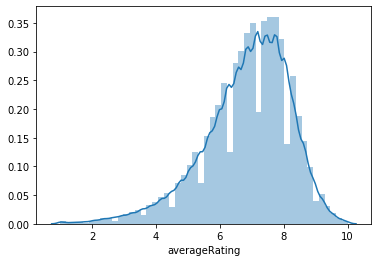

In [19]:
ax = sns.distplot(model_data.averageRating,hist=True)
plt.show()

###### Now we will see that how many movies produces each year and visualize for last 10 years movies. We can see that around 30K movies produces and because of pendamic only around 15K movies produces in this year.

In [44]:
movies_year_wise_count = model_data.startYear.value_counts().reset_index(name = 'movies')
movies_year_wise_count = movies_year_wise_count.rename(columns = {'index':'year'})
movies_year_wise_count = movies_year_wise_count.sort_values(by=['year'], ascending = False)
movies_year_wise_count

,year,movies
135,2021,1
17,2020,14115
7,2019,29301
3,2018,32968
1,2017,35216
...,...,...
137,1885,1
136,1883,1
134,1881,1
132,1878,2


In [45]:
movies_year_wise_count[:10]

,year,movies
135,2021,1
17,2020,14115
7,2019,29301
3,2018,32968
1,2017,35216
0,2016,36275
2,2015,34180
4,2014,32721
5,2013,32290
6,2012,30735


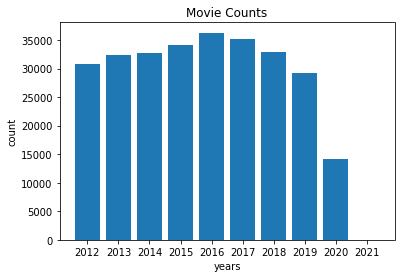

In [47]:
plt.bar(movies_year_wise_count.year[:10],movies_year_wise_count.movies[:10])
plt.xticks(movies_year_wise_count.year[:10])
plt.xlabel('years')
plt.ylabel('count')
plt.title('Movie Counts')
plt.show()

###### Now we will find out what is the average rating for each year. We can see that each year has around 7 ratings out of 10.

In [48]:
movies_ratings_avg = pd.DataFrame(model_data.groupby(['startYear'])['averageRating'].sum().reset_index(name='rating'))
movies_ratings_avg = movies_ratings_avg.sort_values(by=['startYear'], ascending = False)
movies_ratings_avg = movies_ratings_avg.rename( columns = {'startYear':'year'})

In [25]:
movies_ratings_avg

,year,rating
138,2021,7.4
137,2020,99938.2
136,2019,205371.3
135,2018,230159.3
134,2017,248022.6
...,...,...
4,1885,5.3
3,1883,6.4
2,1881,5.3
1,1878,13.4


In [49]:
all_year_ratings = pd.merge(movies_ratings_avg,movies_year_wise_count, on = 'year')
all_year_ratings['avg_rating_yearly'] = round(all_year_ratings.rating / all_year_ratings.movies,2)
all_year_ratings

,year,rating,movies,avg_rating_yearly
0,2021,7.4,1,7.40
1,2020,99938.2,14115,7.08
2,2019,205371.3,29301,7.01
3,2018,230159.3,32968,6.98
4,2017,248022.6,35216,7.04
...,...,...,...,...
134,1885,5.3,1,5.30
135,1883,6.4,1,6.40
136,1881,5.3,1,5.30
137,1878,13.4,2,6.70


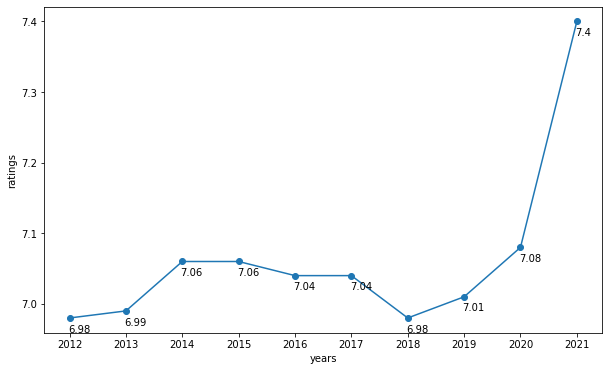

In [50]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(all_year_ratings.year[:10],all_year_ratings.avg_rating_yearly[:10], '-o')
plt.xticks(all_year_ratings.year[:10])
plt.xlabel('years')
plt.ylabel('ratings')
for i,j in zip(all_year_ratings.year[:10],all_year_ratings.avg_rating_yearly[:10]):
    ax.annotate(str(j),xy=(i-0.03,j-0.02))
plt.show()

###### How many movies are adult and what is the average rating. Adult movies only got 6.25 ratings.

In [28]:
is_adult = model_data[model_data.isAdult == 1]
is_adult

,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
39850,tt0061926,4.9,7,movie,Lust Weekend,1,1967,70,Drama
40201,tt0062361,5.9,7,movie,Thigh Spy,1,1967,70,Drama
40253,tt0062417,6.6,12,movie,Un épais manteau de sang,1,1968,88,Drama
40519,tt0062727,4.8,96,short,Of Special Merit,1,1968,11,"Adult,Short"
40853,tt0063118,5.4,10,movie,I Want You!,1,1969,59,Drama
...,...,...,...,...,...,...,...,...,...
1080901,tt9741862,6.4,7,short,The Fall of Communism as Seen in Gay Pornography,1,1998,19,"Adult,Documentary,Short"
1081357,tt9762476,6.2,5,video,Sex Games,1,2018,126,"Adult,Drama,Romance"
1082628,tt9811452,4.8,61,movie,Chikati Gadilo Chithakotudu,1,2019,152,"Adult,Comedy"
1083358,tt9840926,4.8,5,video,Les nuits d'une bourgeoise,1,2017,98,"Adult,Drama,Romance"


In [29]:
adult_average_rating = round(is_adult.averageRating.sum() / len(is_adult),2)
adult_average_rating

6.25

###### There 10 types of format of videos and how many count of each of them. We can see that there are more tv episodes.

In [51]:
type_wise_counting = model_data.titleType.value_counts().reset_index(name='counts')
type_wise_counting = type_wise_counting.rename(columns = {'index':'types'})
type_wise_counting

,types,counts
0,tvEpisode,310919
1,movie,221745
2,short,109255
3,video,48697
4,tvSeries,38973
5,tvMovie,33332
6,tvMiniSeries,6024
7,tvShort,5713
8,tvSpecial,5336
9,videoGame,69


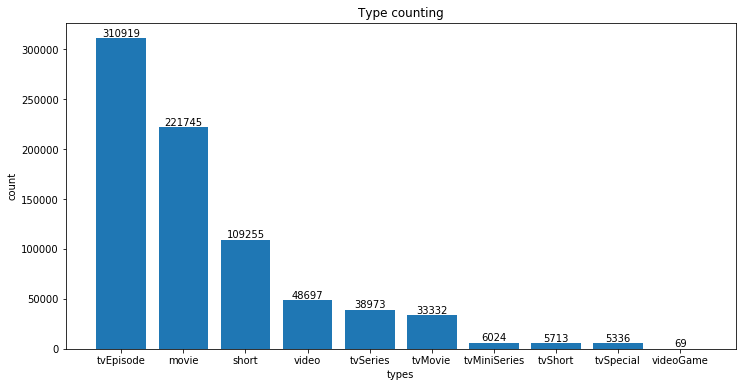

In [53]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
bar1 = plt.bar(type_wise_counting.types,type_wise_counting.counts)
plt.xticks(type_wise_counting.types)
plt.xlabel('types')
plt.ylabel('count')
plt.title('Type counting')
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.show()

###### what is the average rating of each format. we can see that average rating around 6.8 and tv episodes with highest average rating with 7.44

In [55]:
movies_type_ratings_avg = pd.DataFrame(model_data.groupby(['titleType'])['averageRating'].sum().reset_index(name='rating'))
movies_type_ratings_avg = movies_type_ratings_avg.sort_values(by=['titleType'], ascending = False)
movies_type_ratings_avg = movies_type_ratings_avg.rename( columns = {'titleType':'types'})

In [33]:
movies_type_ratings_avg

,types,rating
9,videoGame,459.2
8,video,319400.3
7,tvSpecial,37044.1
6,tvShort,39273.9
5,tvSeries,262849.8
4,tvMovie,218620.3
3,tvMiniSeries,42718.6
2,tvEpisode,2311922.6
1,short,746931.7
0,movie,1362519.1


In [56]:
all_type_ratings = pd.merge(movies_type_ratings_avg,type_wise_counting, on = 'types')
all_type_ratings['avg_rating_type_wise'] = round(all_type_ratings.rating / all_type_ratings.counts,2)
all_type_ratings

,types,rating,counts,avg_rating_type_wise
0,videoGame,459.2,69,6.66
1,video,319400.3,48697,6.56
2,tvSpecial,37044.1,5336,6.94
3,tvShort,39273.9,5713,6.87
4,tvSeries,262849.8,38973,6.74
5,tvMovie,218620.3,33332,6.56
6,tvMiniSeries,42718.6,6024,7.09
7,tvEpisode,2311922.6,310919,7.44
8,short,746931.7,109255,6.84
9,movie,1362519.1,221745,6.14


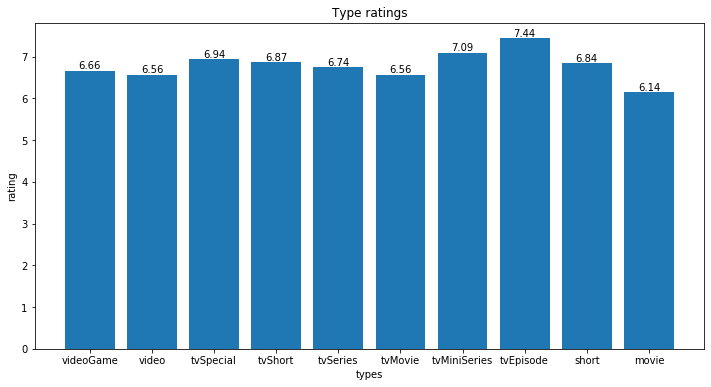

In [57]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
bar1 = plt.bar(all_type_ratings.types,all_type_ratings.avg_rating_type_wise)
plt.xticks(all_type_ratings.types)
plt.xlabel('types')
plt.ylabel('rating')
plt.title('Type ratings')
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % float(height), ha='center', va='bottom')

plt.show()

###### Now we will see average ratings more than whole dataset average rating and minimun votes more than 50K. Which gives higher accuracy for this average as more people have voted for these movies.

In [36]:
higher_voting_ratings = model_data[(model_data.numVotes > 50000) & (model_data.averageRating > 6.25)]
higher_voting_ratings

,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
2756,tt0010323,8.1,56199,movie,The Cabinet of Dr. Caligari,0,1920,76,"Fantasy,Horror,Mystery"
3297,tt0012349,8.3,110522,movie,The Kid,0,1921,68,"Comedy,Drama,Family"
3570,tt0013442,7.9,87377,movie,Nosferatu,0,1922,94,"Fantasy,Horror"
4263,tt0015648,8.0,52180,movie,Battleship Potemkin,0,1925,75,"Drama,History,Thriller"
4340,tt0015864,8.2,98651,movie,The Gold Rush,0,1925,95,"Adventure,Comedy,Drama"
...,...,...,...,...,...,...,...,...,...
1065513,tt9166696,9.9,51884,tvEpisode,Vichnaya Pamyat,0,2019,72,"Drama,History,Thriller"
1068018,tt9243946,7.3,175643,movie,El Camino: A Breaking Bad Movie,0,2019,122,"Action,Crime,Drama"
1074730,tt9484998,7.4,52545,movie,Palm Springs,0,2020,90,"Comedy,Fantasy,Mystery"
1074961,tt9495224,7.2,110730,tvMovie,Black Mirror: Bandersnatch,0,2018,90,"Drama,Mystery,Sci-Fi"


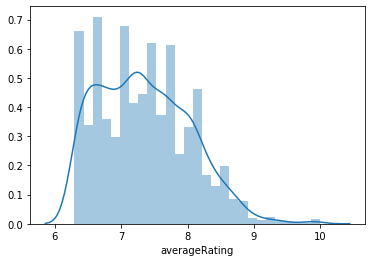

In [37]:
ax = sns.distplot(higher_voting_ratings.averageRating,hist=True)
plt.show()

###### Now we will see which genre is more common than any other genre. We will use word cloud and bar graph to understand. We can see that drama is most common genre according to our dataset.

In [20]:
word_cloud_list = list(model_data.genres)
word_cloud_list = ','.join(word_cloud_list)
word_cloud_list = word_cloud_list.split(',')

In [38]:
word_could_dict = Counter(word_cloud_list)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

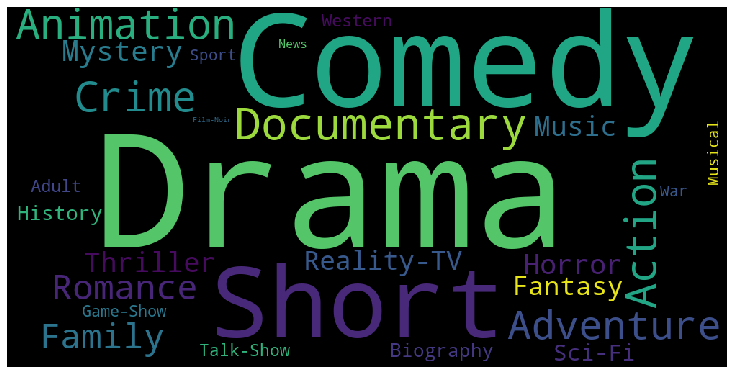

In [39]:
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

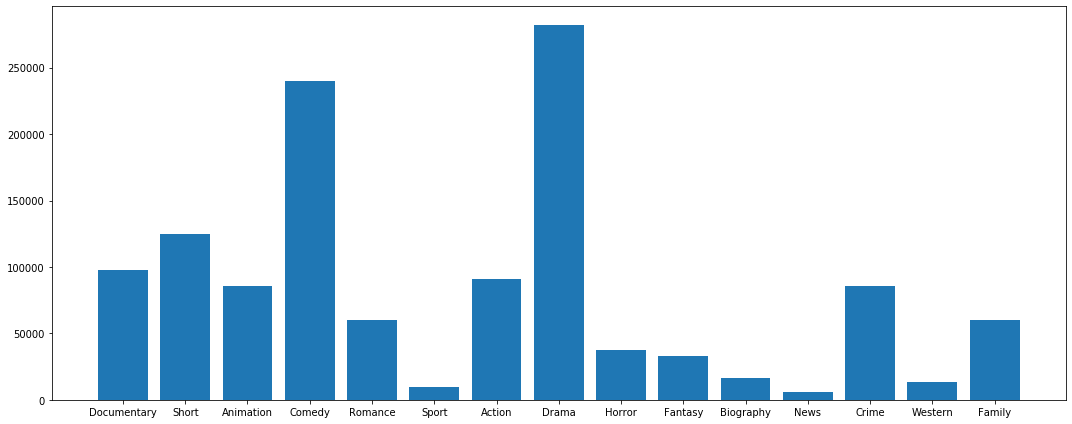

In [40]:
plt.figure(figsize=(15,6))
plt.bar(list(word_could_dict.keys())[:15],list(word_could_dict.values())[:15])
plt.tight_layout()
plt.show()

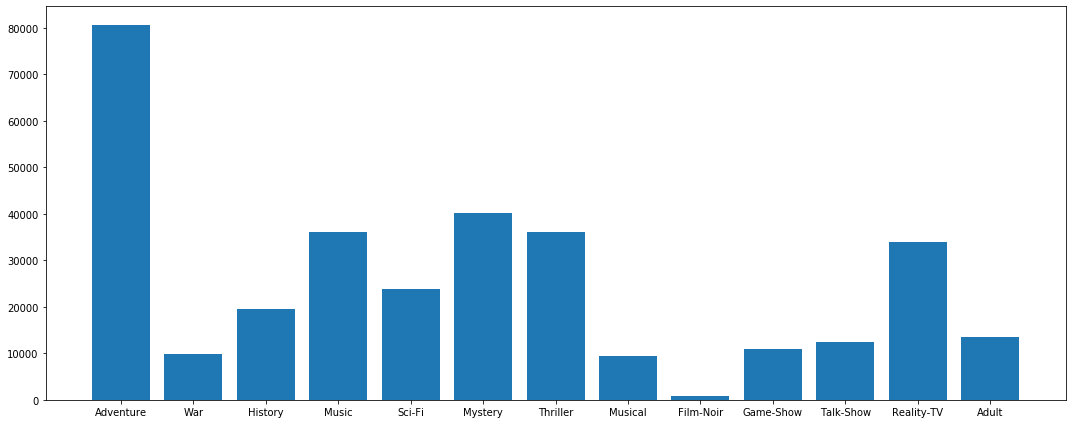

In [41]:
plt.figure(figsize=(15,6))
plt.bar(list(word_could_dict.keys())[15:],list(word_could_dict.values())[15:])
plt.tight_layout()
plt.show()

## 6) Recommendations

###### we will use weighted rating formula to give each movie a weighted rating and then see in descending order. 
###### weighted rating  = (v/(v+m) * R) + (m/(m+v) * C) where,
###### m = minimun votes
###### C = average rating
###### R = particular movie rating
###### v = particular movie votes

In [13]:
votes = model_data['numVotes']
m = votes.quantile(0.95)
C = model_data.averageRating.mean()

In [14]:
C

6.847831008521324

In [15]:
m

1700.0

In [45]:
model_data

,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,5.6,1654,short,Carmencita,0,1894,1,"Documentary,Short"
1,tt0000002,6.1,199,short,Le clown et ses chiens,0,1892,5,"Animation,Short"
2,tt0000003,6.5,1365,short,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance"
3,tt0000004,6.2,121,short,Un bon bock,0,1892,12,"Animation,Short"
4,tt0000005,6.2,2149,short,Blacksmith Scene,0,1893,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
1085347,tt9916544,7.2,24,short,My Sweet Prince,0,2019,12,"Drama,Short"
1085348,tt9916576,5.5,10,tvEpisode,Destinee's Story,0,2019,85,Reality-TV
1085350,tt9916580,7.2,5,tvEpisode,Horrid Henry Horrid Boy?,0,2012,10,"Animation,Comedy,Family"
1085352,tt9916720,6.0,64,short,The Nun 2,0,2019,10,"Comedy,Horror,Mystery"


In [16]:
def weighted_ratings(model_data):
    v = model_data['numVotes']
    R = model_data['averageRating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
model_data['wr'] = model_data.apply(weighted_ratings, axis=1)

In [18]:
model_data = model_data.sort_values(by = ['wr'], ascending = False)

,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,wr
710104,tt2301451,10.0,121532,tvEpisode,Ozymandias,0,2013,48,"Crime,Drama,Thriller",9.956515
839244,tt4283088,9.9,187777,tvEpisode,Battle of the Bastards,0,2016,60,"Action,Adventure,Drama",9.872616
839245,tt4283094,9.9,130855,tvEpisode,The Winds of Winter,0,2016,68,"Action,Adventure,Drama",9.860856
694562,tt2178784,9.9,88965,tvEpisode,The Rains of Castamere,0,2013,51,"Action,Adventure,Drama",9.842771
816521,tt3866850,9.9,88707,tvEpisode,Hardhome,0,2015,61,"Action,Adventure,Drama",9.842607
...,...,...,...,...,...,...,...,...,...,...
823623,tt4009460,1.4,14858,movie,Kirk Cameron's Saving Christmas,0,2014,79,"Comedy,Family",1.959326
626051,tt1702443,1.6,75065,movie,Justin Bieber: Never Say Never,0,2011,105,"Documentary,Music",1.716216
932477,tt5988370,1.4,72215,movie,Reis,0,2017,108,"Biography,Drama",1.525297
1020431,tt7886848,1.1,58248,movie,Sadak 2,0,2020,133,"Action,Drama",1.262996


###### Now we will create new columns for each genre and split genre column.

In [21]:
word_cloud_list = list(set(word_cloud_list))
for i in word_cloud_list:
    model_data[i] = 0

In [22]:
for i in model_data.index:
    x = model_data['genres'][i].split(',')
    for k in x:
        model_data[k][i] = 1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
model_data

,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,wr,...,Talk-Show,Action,Western,Fantasy,Adult,Game-Show,History,Short,Family,War
710104,tt2301451,10.0,121532,tvEpisode,Ozymandias,0,2013,48,"Crime,Drama,Thriller",9.956515,...,0,0,0,0,0,0,0,0,0,0
839244,tt4283088,9.9,187777,tvEpisode,Battle of the Bastards,0,2016,60,"Action,Adventure,Drama",9.872616,...,0,1,0,0,0,0,0,0,0,0
839245,tt4283094,9.9,130855,tvEpisode,The Winds of Winter,0,2016,68,"Action,Adventure,Drama",9.860856,...,0,1,0,0,0,0,0,0,0,0
694562,tt2178784,9.9,88965,tvEpisode,The Rains of Castamere,0,2013,51,"Action,Adventure,Drama",9.842771,...,0,1,0,0,0,0,0,0,0,0
816521,tt3866850,9.9,88707,tvEpisode,Hardhome,0,2015,61,"Action,Adventure,Drama",9.842607,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823623,tt4009460,1.4,14858,movie,Kirk Cameron's Saving Christmas,0,2014,79,"Comedy,Family",1.959326,...,0,0,0,0,0,0,0,0,1,0
626051,tt1702443,1.6,75065,movie,Justin Bieber: Never Say Never,0,2011,105,"Documentary,Music",1.716216,...,0,0,0,0,0,0,0,0,0,0
932477,tt5988370,1.4,72215,movie,Reis,0,2017,108,"Biography,Drama",1.525297,...,0,0,0,0,0,0,0,0,0,0
1020431,tt7886848,1.1,58248,movie,Sadak 2,0,2020,133,"Action,Drama",1.262996,...,0,1,0,0,0,0,0,0,0,0


###### We will take all genre column to create a clusters based on their values and then we scale each values.

In [24]:
cluster_data = model_data[['primaryTitle'] + word_cloud_list]

In [25]:
cluster_data

,primaryTitle,Mystery,News,Animation,Sci-Fi,Adventure,Music,Horror,Documentary,Musical,...,Talk-Show,Action,Western,Fantasy,Adult,Game-Show,History,Short,Family,War
710104,Ozymandias,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
839244,Battle of the Bastards,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
839245,The Winds of Winter,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
694562,The Rains of Castamere,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
816521,Hardhome,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823623,Kirk Cameron's Saving Christmas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
626051,Justin Bieber: Never Say Never,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
932477,Reis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1020431,Sadak 2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [27]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cluster_data.iloc[:,1:])

###### We will create a graph for 1 to 50 clusters and use elbow techinique to understand optiomal cluster to be choose.

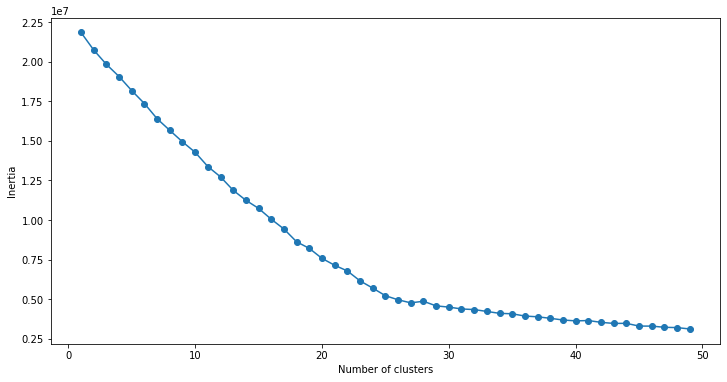

In [40]:

SSE = []
for cluster in range(1,50):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

frame = pd.DataFrame({'Cluster':range(1,50), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


###### we will take 28 clusters and predict on our data.

In [30]:
data_scaled = data_scaled.astype('float32')
kmeans = KMeans(n_clusters=28, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)
final = pd.DataFrame(data_scaled)
final['cluster'] = pred
final

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,cluster
0,-0.233143,-0.089034,-0.35158,-0.177664,-0.339469,-0.220083,-0.225104,-0.378990,-0.11037,4.532936,...,-0.363670,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,25
1,-0.233143,-0.089034,-0.35158,-0.177664,2.945777,-0.220083,-0.225104,-0.378990,-0.11037,-0.220608,...,2.749748,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,4
2,-0.233143,-0.089034,-0.35158,-0.177664,2.945777,-0.220083,-0.225104,-0.378990,-0.11037,-0.220608,...,2.749748,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,4
3,-0.233143,-0.089034,-0.35158,-0.177664,2.945777,-0.220083,-0.225104,-0.378990,-0.11037,-0.220608,...,2.749748,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,4
4,-0.233143,-0.089034,-0.35158,-0.177664,2.945777,-0.220083,-0.225104,-0.378990,-0.11037,-0.220608,...,2.749748,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780058,-0.233143,-0.089034,-0.35158,-0.177664,-0.339469,-0.220083,-0.225104,-0.378990,-0.11037,-0.220608,...,-0.363670,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,3.470209,-0.112965,26
780059,-0.233143,-0.089034,-0.35158,-0.177664,-0.339469,4.543739,-0.225104,2.638595,-0.11037,-0.220608,...,-0.363670,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,13
780060,-0.233143,-0.089034,-0.35158,-0.177664,-0.339469,-0.220083,-0.225104,-0.378990,-0.11037,-0.220608,...,-0.363670,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,20
780061,-0.233143,-0.089034,-0.35158,-0.177664,-0.339469,-0.220083,-0.225104,-0.378990,-0.11037,-0.220608,...,2.749748,-0.13093,-0.210061,-0.133096,-0.119667,-0.160239,-0.436796,-0.288167,-0.112965,5


###### We can see how many values are in each clusters. We will use this for recommending movie based on genre.

In [31]:
final['cluster'].value_counts()

1     82399
5     68697
7     68049
21    62193
2     45783
26    43438
24    41020
4     39803
22    29481
13    29273
17    28148
25    27234
3     26857
14    26131
23    22797
19    22215
20    15093
0     13483
15    13437
16    13014
8     10389
11     9773
9      9634
12     9381
10     9216
27     6203
18     6135
6       787
Name: cluster, dtype: int64

In [33]:
model_data['cluster'] = list(final['cluster'])

###### This is our final function. Function will take different arguments. We can either provide that information or not. This is currently only giving one genre based recommendation. We can give either title, types, minimum ratings, year or genre. It will recommend 15 movies based on information we provide. 

In [34]:
def get_recommendations(title=None,types = None,ratings=None,year=None,genres=None):
    x = model_data
    if title != None:
        cluster_no = list(x[x['primaryTitle'].str.lower() == title.lower()]['cluster'])
        x = x[x['cluster'] == random.choice(cluster_no)]
    if types != None:
        x = x[x['titleType'].str.lower() == types.lower()]
    if year != None:
        x = x[x['startYear'] == year]
    if genres != None:
        list_of_genres = genres.split('|')
        x = x[x[genres.capitalize()] == 1]
    if ratings != None:
        x = x[x['wr'] >= ratings]
    
    return x[:15]
        

###### We have given four inputs. movie name, title-type, minimun ratings and genre. based on that it gave us 15 recommendations. 

In [41]:
get_recommendations(title = 'thor',types = 'movie',ratings = 7, genres = 'drama')

[1, 22, 15, 20, 10, 7, 21, 22]


,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,wr,...,Action,Western,Fantasy,Adult,Game-Show,History,Short,Family,War,cluster
208843,tt0379557,8.0,33271,movie,Touching the Void,0,2003,106,"Adventure,Documentary,Drama",7.943991,...,0,0,0,0,0,0,0,0,0,7
211756,tt0386032,7.9,73325,movie,Sicko,0,2007,123,"Documentary,Drama",7.876159,...,0,0,0,0,0,0,0,0,0,7
1058471,tt8991268,8.0,12773,movie,Honeyland,0,2019,89,"Documentary,Drama",7.864666,...,0,0,0,0,0,0,0,0,0,7
59317,tt0084628,8.0,9387,movie,Sans Soleil,0,1983,104,"Documentary,Drama",7.823335,...,0,0,0,0,0,0,0,0,0,7
255599,tt0493393,8.2,3909,movie,Ashes and Snow,0,2005,62,"Documentary,Drama",7.790179,...,0,0,0,0,0,0,0,0,0,7
498715,tt11464826,7.7,44361,movie,The Social Dilemma,0,2020,94,"Documentary,Drama",7.668549,...,0,0,0,0,0,0,0,0,0,7
370046,tt0765128,7.8,9004,movie,Oceans,0,2009,104,"Documentary,Drama",7.648777,...,0,0,0,0,0,0,0,0,0,7
42410,tt0064921,7.8,4650,movie,Salesman,0,1969,91,"Documentary,Drama",7.545089,...,0,0,0,0,0,0,0,0,0,7
663145,tt1942884,7.6,20144,movie,Indie Game: The Movie,0,2012,103,"Documentary,Drama",7.541463,...,0,0,0,0,0,0,0,0,0,7
623593,tt1687247,7.6,14778,movie,Life in a Day,0,2011,95,"Documentary,Drama",7.522400,...,0,0,0,0,0,0,0,0,0,7


In [42]:
get_recommendations(types = 'movie',ratings = 7, genres = 'drama')

,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,wr,...,Action,Western,Fantasy,Adult,Game-Show,History,Short,Family,War,cluster
81675,tt0111161,9.3,2296075,movie,The Shawshank Redemption,0,1994,142,Drama,9.298186,...,0,0,0,0,0,0,0,0,0,5
45645,tt0068646,9.2,1584840,movie,The Godfather,0,1972,175,"Crime,Drama",9.197480,...,0,0,0,0,0,0,0,0,0,24
152282,tt0252487,9.3,36503,movie,The Chaos Class,0,1975,87,"Comedy,Drama",9.190881,...,0,0,0,0,0,0,0,0,0,1
245567,tt0468569,9.0,2260718,movie,The Dark Knight,0,2008,152,"Action,Crime,Drama",8.998383,...,1,0,0,0,0,0,0,0,0,24
48171,tt0071562,9.0,1107291,movie,The Godfather: Part II,0,1974,202,"Crime,Drama",8.996701,...,0,0,0,0,0,0,0,0,0,24
81459,tt0110912,8.9,1792981,movie,Pulp Fiction,0,1994,154,"Crime,Drama",8.898056,...,0,0,0,0,0,0,0,0,0,24
112689,tt0167260,8.9,1614420,movie,The Lord of the Rings: The Return of the King,0,2003,201,"Action,Adventure,Drama",8.897841,...,1,0,0,0,0,0,0,0,0,4
79116,tt0108052,8.9,1191841,movie,Schindler's List,0,1993,195,"Biography,Drama,History",8.897077,...,0,0,0,0,0,1,0,0,0,20
29632,tt0050083,8.9,674658,movie,12 Angry Men,0,1957,96,"Crime,Drama",8.894842,...,0,0,0,0,0,0,0,0,0,24
97925,tt0137523,8.8,1820342,movie,Fight Club,0,1999,139,Drama,8.798179,...,0,0,0,0,0,0,0,0,0,5


In [43]:
get_recommendations(title = 'thor',types = 'movie',ratings = 7)

[1, 22, 15, 20, 10, 7, 21, 22]


,tconst,averageRating,numVotes,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,wr,...,Action,Western,Fantasy,Adult,Game-Show,History,Short,Family,War,cluster
695406,tt2185022,9.2,6646,movie,Love on a Leash,0,2011,90,"Comedy,Drama,Fantasy",8.720886,...,0,0,1,0,0,0,0,0,0,22
55957,tt0080684,8.7,1139328,movie,Star Wars: Episode V - The Empire Strikes Back,0,1980,124,"Action,Adventure,Fantasy",8.697240,...,1,0,1,0,0,0,0,0,0,22
52581,tt0076759,8.6,1211077,movie,Star Wars: Episode IV - A New Hope,0,1977,121,"Action,Adventure,Fantasy",8.597544,...,1,0,1,0,0,0,0,0,0,22
89414,tt0120689,8.6,1122328,movie,The Green Mile,0,1999,189,"Crime,Drama,Fantasy",8.597350,...,0,0,1,0,0,0,0,0,0,22
20274,tt0038650,8.6,390901,movie,It's a Wonderful Life,0,1946,130,"Drama,Family,Fantasy",8.592413,...,0,0,1,0,0,0,0,1,0,22
88594,tt0119698,8.4,334636,movie,Princess Mononoke,0,1997,134,"Adventure,Animation,Fantasy",8.392155,...,0,0,1,0,0,0,0,0,0,22
895599,tt5311514,8.4,183283,movie,Your Name.,0,2016,106,"Animation,Drama,Fantasy",8.385736,...,0,0,1,0,0,0,0,0,0,22
60643,tt0086190,8.3,933833,movie,Star Wars: Episode VI - Return of the Jedi,0,1983,131,"Action,Adventure,Fantasy",8.297361,...,1,0,1,0,0,0,0,0,0,22
1033331,tt8239946,8.3,25288,movie,Tumbbad,0,2018,104,"Drama,Fantasy,Horror",8.208526,...,0,0,1,0,0,0,0,0,0,22
48434,tt0071853,8.2,494411,movie,Monty Python and the Holy Grail,0,1975,91,"Adventure,Comedy,Fantasy",8.195367,...,0,0,1,0,0,0,0,0,0,22
